In [2]:
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from mpl_interactions import ioff, panhandler, zoom_factory
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import sys
from datetime import datetime
from scipy.optimize import curve_fit
from lmfit import Model

In [4]:
def LoadRun(file):

    # Load the data
    data = pd.read_hdf(file, "data")
    data_properties = pd.read_hdf(file, "data_properties")

    # Convert 'event' columns to integers
    data['event'] = data['event'].astype(int)
    data_properties['event'] = data_properties['event'].astype(int)

    # Get event_ids where 'x' or 'y' has NaN values
    nan_event_ids = data_properties[data_properties['x'].isna()]['event'].values
    nan_event_ids = np.append(nan_event_ids, data_properties[data_properties['y'].isna()]['event'].values)

    # Filter out rows in data and data_properties based on the 'event' column
    data_properties = data_properties[~data_properties['event'].isin(nan_event_ids)]
    data = data[~data['event'].isin(nan_event_ids)]

    return data_properties, data


Run_13850_prop, Run_13850 =  LoadRun("../data/analysis/Run_13850_FilteredRaw.h5")
Run_14180_prop, Run_14180 =  LoadRun("../data/analysis/Run_14180_FilteredRaw.h5")

Text(804.5, 0.175, '803.5 $\\mu$s')

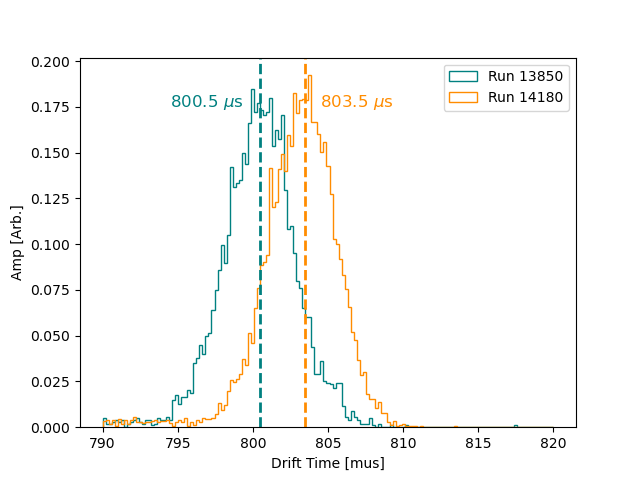

In [23]:
%matplotlib widget
plt.figure()

plt.hist(Run_13850_prop.deltaT, bins = np.linspace(790, 820, 150), histtype = "step" ,color = "Teal", label = "Run 13850", density=True);
plt.hist(Run_14180_prop.deltaT, bins = np.linspace(790, 820, 150), histtype = "step" ,color = "DarkOrange", label = "Run 14180", density=True);
plt.xlabel("Drift Time [mus]")
plt.ylabel("Amp [Arb.]")
plt.legend()
# plt.xlim("790,")

plt.axvline(800.5, linestyle = "--", color = "Teal", linewidth = 2)
plt.axvline(803.5, linestyle = "--", color = "DarkOrange", linewidth = 2)

plt.text(794.5, 0.175, r'800.5 $\mu$s', fontsize=12, color = "Teal")
plt.text(804.5, 0.175, r'803.5 $\mu$s', fontsize=12, color = "DarkOrange")

In [25]:
# Rebin the x and y

def BinXY(data_properties):

    # Define bin edges using np.linspace for x and y
    x_bins = np.linspace(-500, 500, 10)  # 10 evenly spaced bins between -500 and 500
    y_bins = np.linspace(-500, 500, 10)

    # Bin the x and y columns
    data_properties['x_bin'] = pd.cut(data_properties['x'], bins=x_bins, labels=False)  # Labels as index (0, 1, 2,...)
    data_properties['y_bin'] = pd.cut(data_properties['y'], bins=y_bins, labels=False)

    # Calculate bin centers
    x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2  # Bin centers for x
    y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers for y

    # Assign the bin centers as new columns
    data_properties['x_bin_center'] = data_properties['x_bin'].map(lambda i: x_bin_centers[i] if pd.notna(i) else np.nan)
    data_properties['y_bin_center'] = data_properties['y_bin'].map(lambda i: y_bin_centers[i] if pd.notna(i) else np.nan)

    # Assign a unique bin ID for each (x_bin, y_bin) pair
    data_properties['bin_id'] = data_properties['x_bin'].astype(str) + '_' + data_properties['y_bin'].astype(str)

    data_properties['sigma'] = data_properties['sigma'].fillna(0)
    data_properties['S2_amp'] = data_properties['S2_amp'].fillna(-1)
    data_properties = data_properties[data_properties.S2_amp > 0]

    return data_properties

Run_13850_prop = BinXY(Run_13850_prop)
Run_14180_prop = BinXY(Run_14180_prop)


In [26]:
# Define the exponential decay function
def exp_decay(t, q, tau):
    return q * np.exp(-t / tau)

def FitLifetime(df, binid):

    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == binid] 

    # Get the histogram with the most counts to find the main alpha peak
    counts, bin_edges = np.histogram(df_bin.S2_area, bins=50) 
    max_bin_index = np.argmax(counts)  # Index of the bin with the most counts
    max_bin_value = bin_edges[max_bin_index]  # Left edge of the bin with the most counts

    lower_bound = max_bin_value-0.25e8 + 0.3e8
    upper_bound = max_bin_value+0.25e8 + 0.3e8

    df_bin = df_bin[ (df_bin.S2_area > -5e4*df_bin.deltaT+lower_bound) & (df_bin.S2_area < -5e4*df_bin.deltaT+upper_bound)  ]

    if (len(df_bin) < 20):
        return 0, 0

    # Make 2D hist for binning
    hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=100)
    
    # Perform the curve fit
    params, covariance = curve_fit(exp_decay, df_bin.deltaT, df_bin.S2_area, p0=[max_bin_value, 80e3 ], bounds = ([1e8, 1e3], [4.5e8, 100e3]))


    # Extract the fitted parameters
    q_fit, tau_fit = params
    # print(q_fit/1e8, tau_fit/1e3 )

    return q_fit, tau_fit


# Define the plot function
def plot_lifetime(ax, df, S2var, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(df_bin['deltaT'], df_bin[S2var], bins=100)

    # Mask zero bins
    masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

    # Custom colormap
    # cmap = plt.cm.viridis
    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='white')  # Set masked values (zeros) to white

    # Plot with pcolormesh
    pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

    # Add color bar
    plt.colorbar(pcm, ax=ax, label='Counts')

    # Set labels
    ax.set_xlabel("Drift Time [μs]")
    ax.set_ylabel("S2 Area [PE]")
    ax.set_title(f"Bin {bin_id}")
    ax.set_ylim(2.5e8,4.5e8)

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_5063/1091503710.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_5063/1091503710.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_5063/1091503710.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_5063/1091503710.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_5063/1091503710.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_5063/1091503710.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp

,bin_id,lt,q0
0,0_9,0,0
1,1_9,0,0
2,2_9,0,0
3,3_9,0,0
4,4_9,0,0
...,...,...,...
76,4_1,7882.512995,347967021.09018
77,5_1,8687.085817,360213313.114058
78,6_1,8872.855796,382219183.355716
79,7_1,9598.582103,374847894.636571


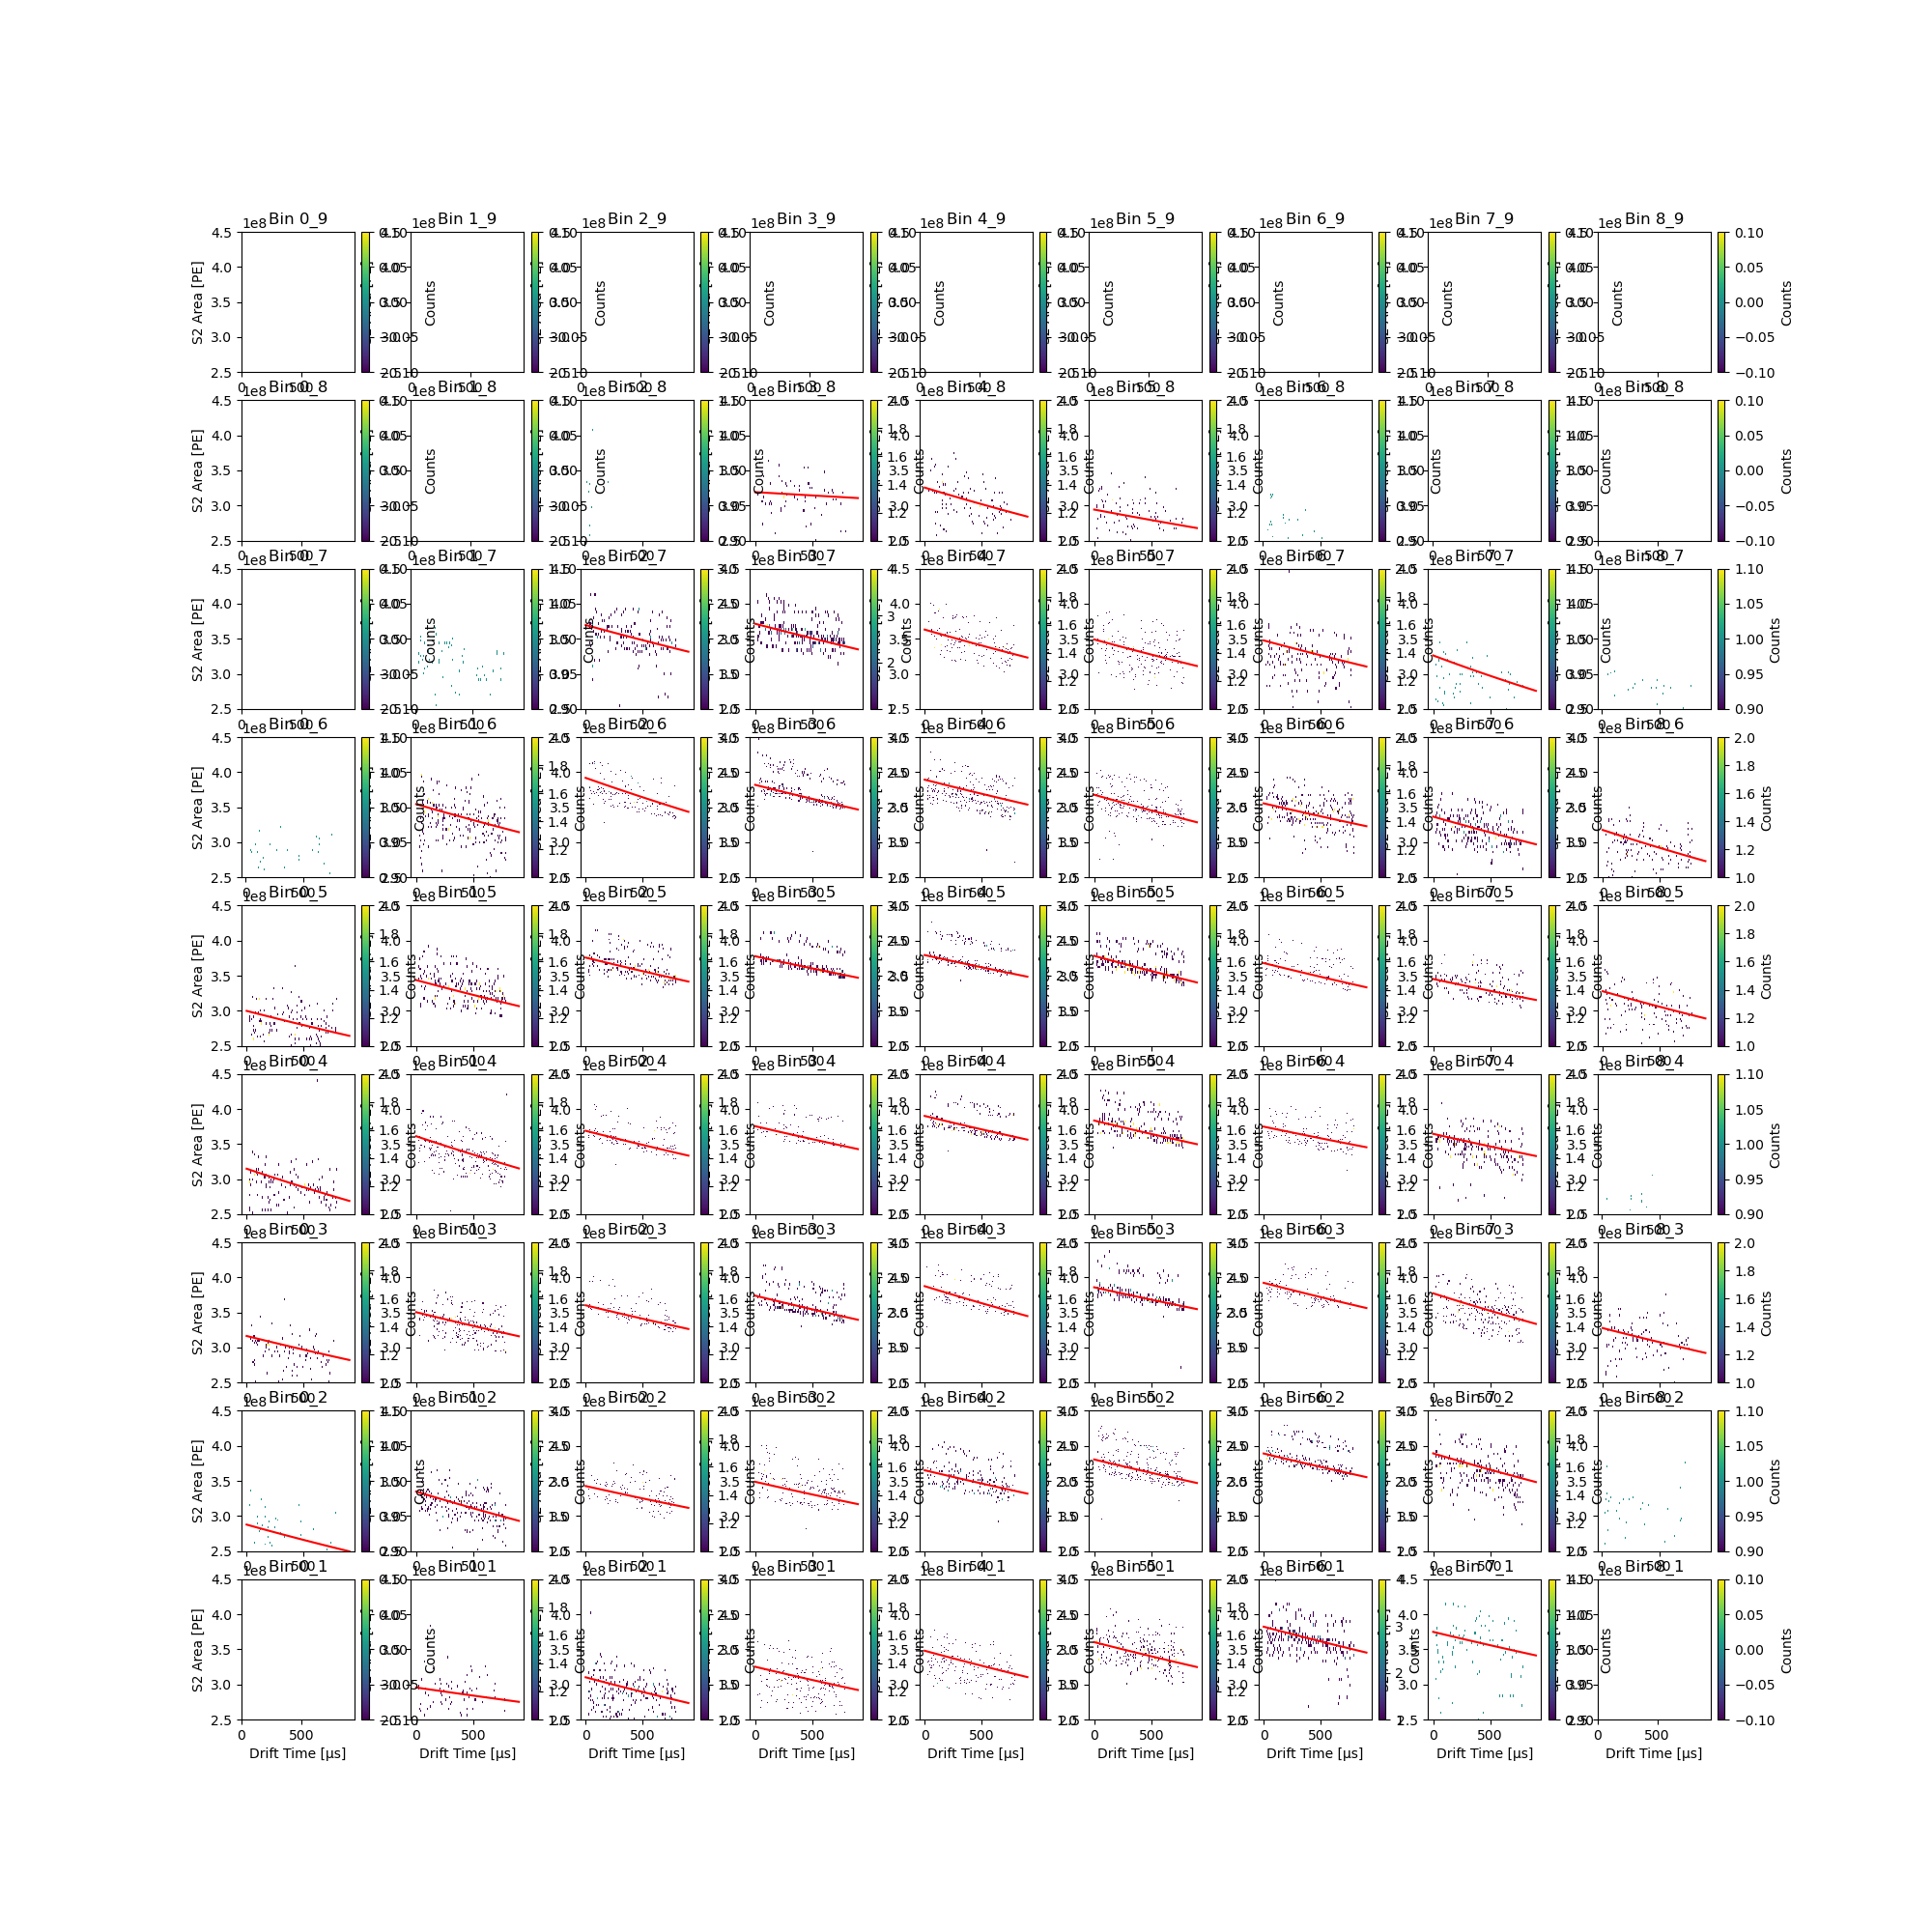

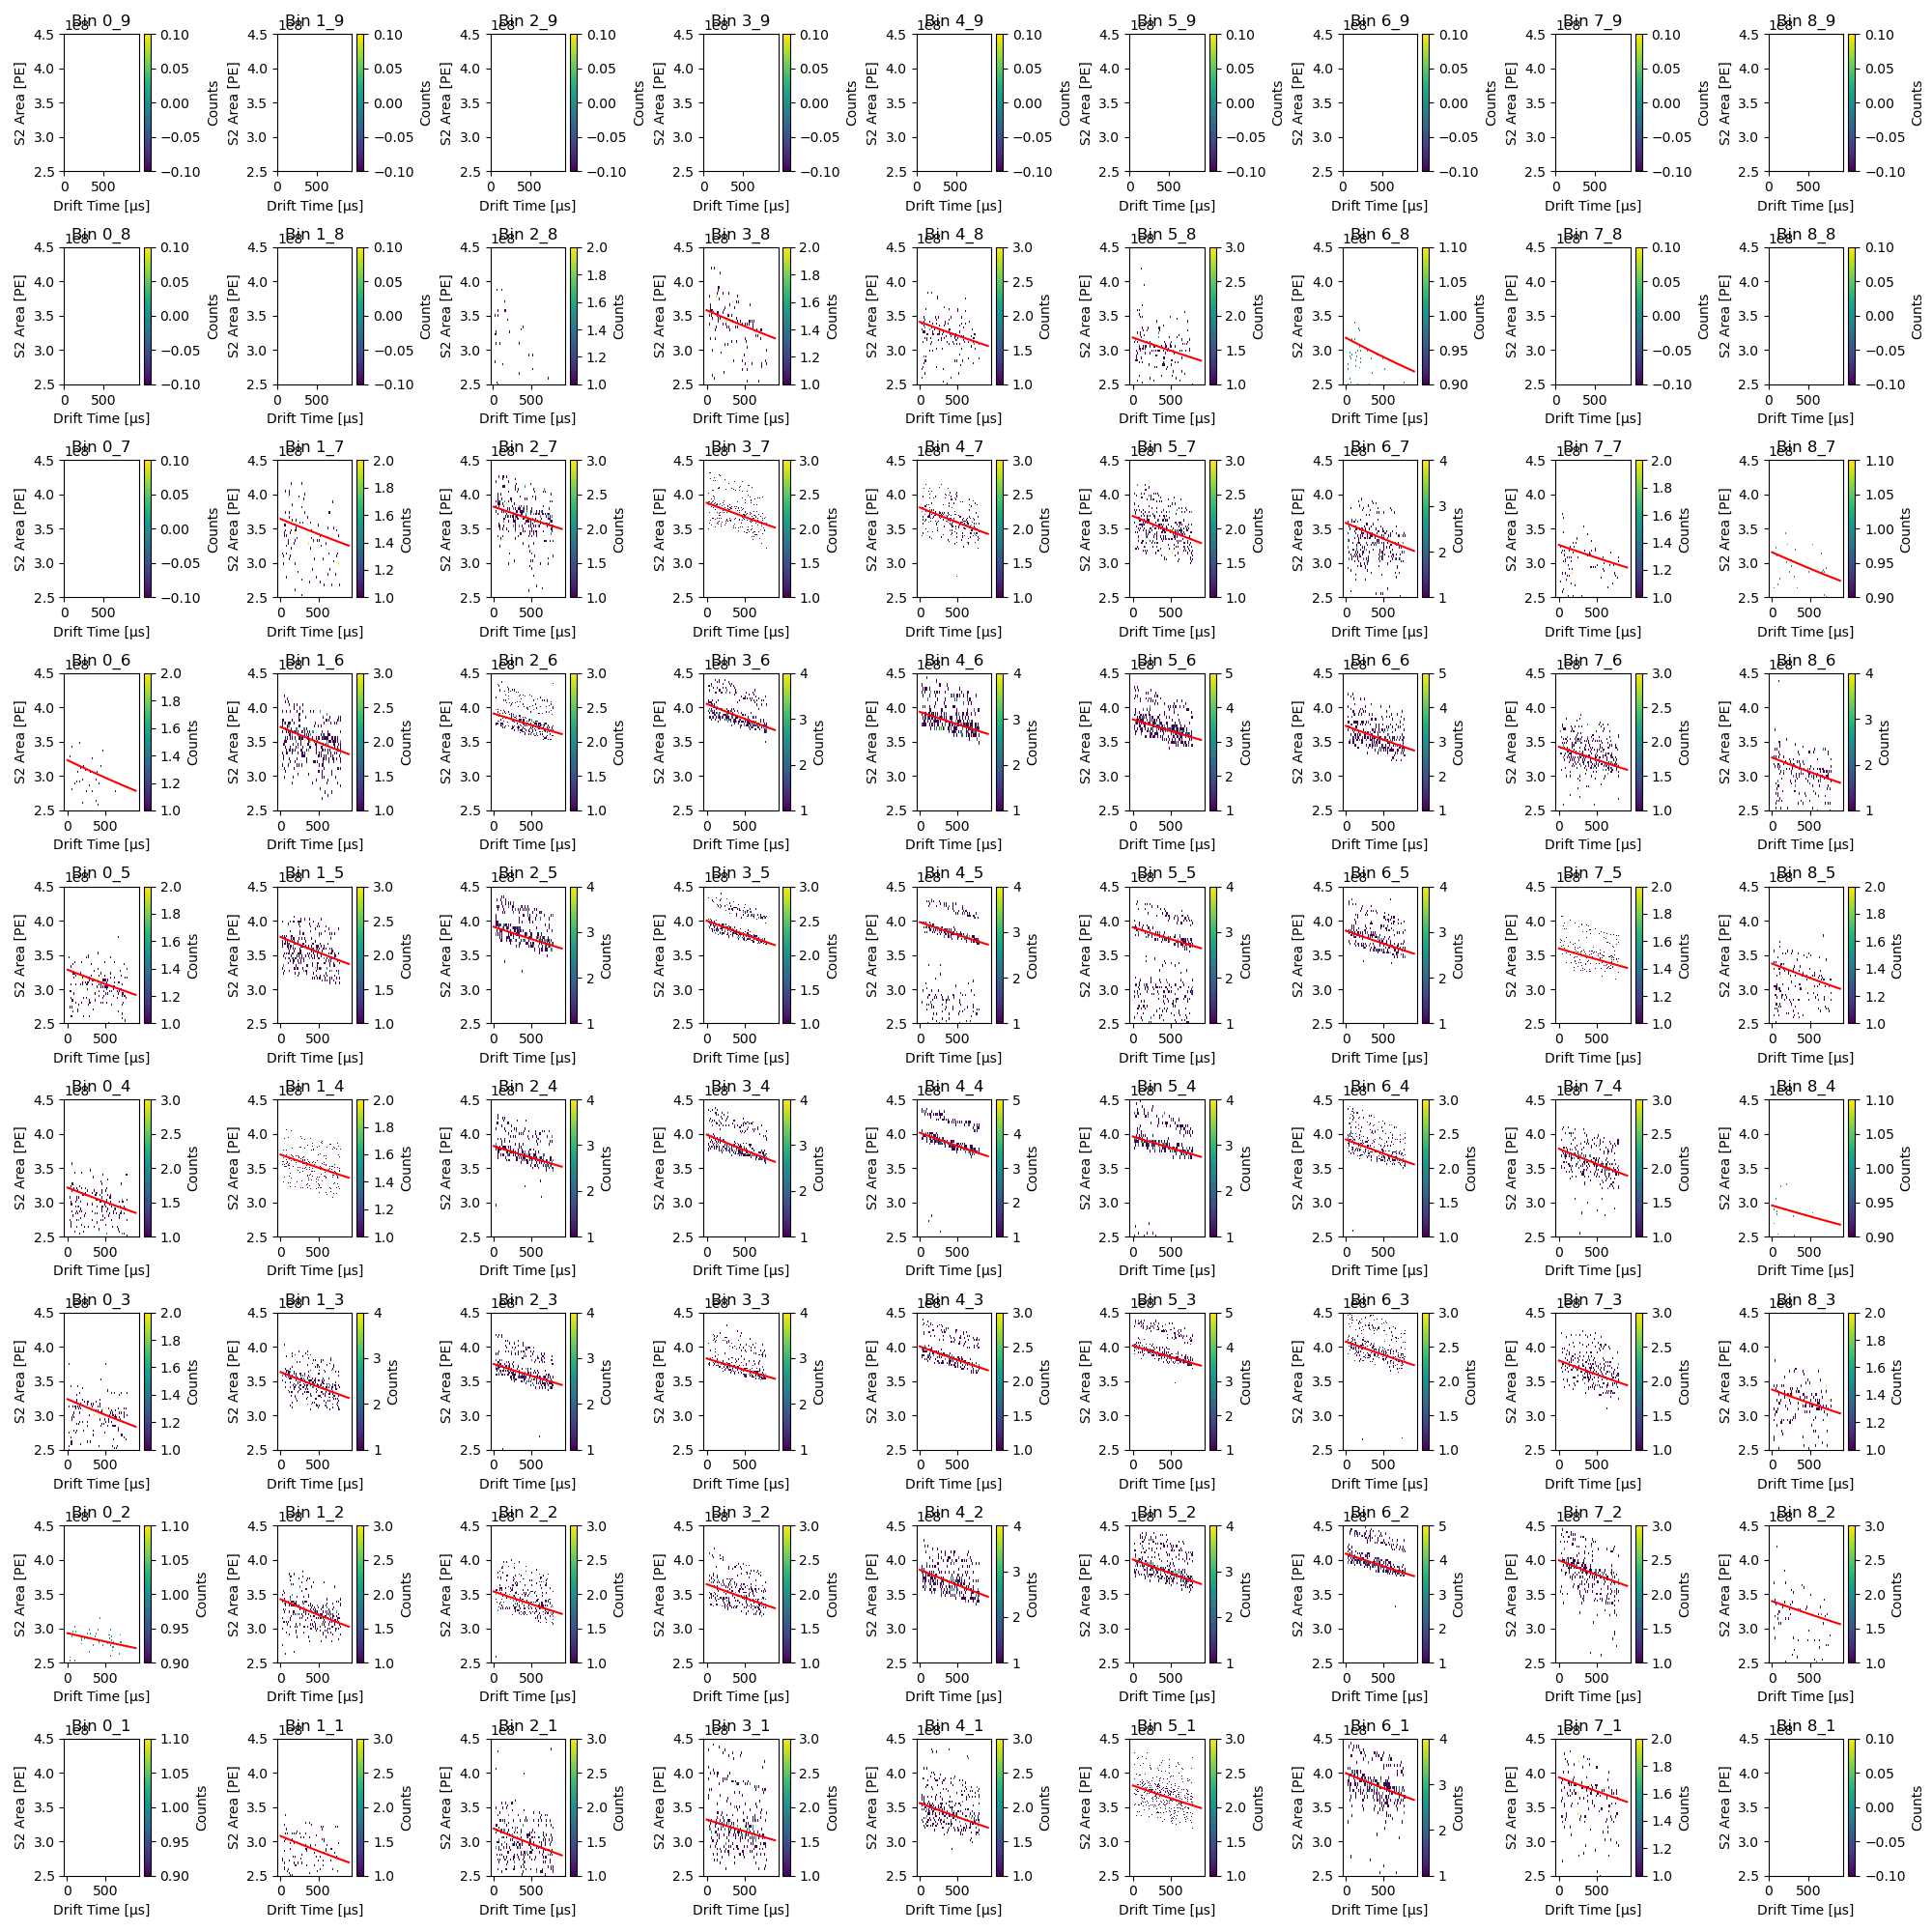

In [48]:
# Make a plot of the time vs peak width


def GetLifetimes(data_properties_active):

    # Create a grid of subplots (5x5)
    fig, axs = plt.subplots(9, 9, figsize=(20, 20))  # Adjusted figsize for better spacing
    axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

    lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

    # Iterate over the unique bin_id values and corresponding subplot axes
    counter = 0
    for y in range(9, -1, -1):
        for x in range(0, 9, 1):
            if counter >= len(axs):
                break  # Avoid indexing beyond available subplots
            plot_lifetime(axs[counter], data_properties_active, "S2_area",f"{x}_{y}")

            t_fit = np.linspace(0, 900, 100)

            q_fit, tau_fit = FitLifetime(data_properties_active, f"{x}_{y}")
            hist_fit = exp_decay(t_fit, q_fit, tau_fit)

            # # Plotting the fitted exponential decay curve
            axs[counter].plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')

            # Create a new DataFrame to append
            new_data = pd.DataFrame({
                "bin_id": [f"{x}_{y}"],
                "lt": [tau_fit],
                "q0": [q_fit]
            })

            lifetime_df = pd.concat([lifetime_df, new_data], ignore_index=True)

            counter=counter+1

    return lifetime_df

Run_13850_prop_lt = GetLifetimes(Run_13850_prop[ (Run_13850_prop.deltaT < 794) & (Run_13850_prop.deltaT > 0)])
Run_14180_prop_lt = GetLifetimes(Run_14180_prop[ (Run_14180_prop.deltaT < 794) & (Run_14180_prop.deltaT > 0)])

# Adjust layout to avoid overlap
plt.tight_layout()

display(Run_13850_prop_lt)

Mean LT Run 13850: 9.001174208233644 3.5740265062497607
Mean LT Run 14180: 9.019293403127289 1.481882467964567
Mean q0 Run 13850: 3.5511701862995766 0.2838082761588233
Mean q0 Run 14180: 3.653106732670235 0.3150839551834278


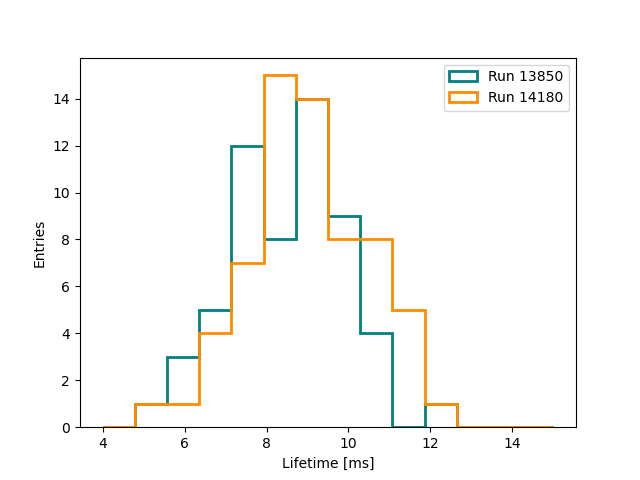

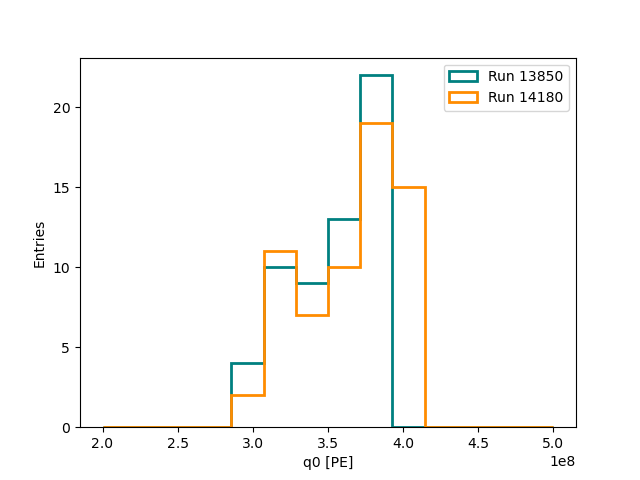

In [58]:
plt.figure()

Run_13850_prop_lt_filt = Run_13850_prop_lt[Run_13850_prop_lt["lt"] > 0]
Run_14180_prop_lt_filt = Run_14180_prop_lt[Run_14180_prop_lt["lt"] > 0]

plt.hist(Run_13850_prop_lt_filt["lt"]/1000, bins = np.linspace(4,15, 15), histtype ="step", color = "Teal", label = "Run 13850", linewidth = 2);
plt.hist(Run_14180_prop_lt_filt["lt"]/1000, bins = np.linspace(4,15, 15), histtype ="step", color = "DarkOrange", label = "Run 14180", linewidth = 2);
plt.legend()
plt.xlabel("Lifetime [ms]")
plt.ylabel("Entries")

print("Mean LT Run 13850:", Run_13850_prop_lt_filt["lt"].mean()/1000, Run_13850_prop_lt_filt["lt"].std()/1000)
print("Mean LT Run 14180:", Run_14180_prop_lt_filt["lt"].mean()/1000, Run_14180_prop_lt_filt["lt"].std()/1000)


plt.figure()
plt.hist(Run_13850_prop_lt_filt["q0"], bins = np.linspace(2e8,5e8, 15) ,histtype ="step", color = "Teal", label = "Run 13850", linewidth = 2);
plt.hist(Run_14180_prop_lt_filt["q0"], bins = np.linspace(2e8,5e8, 15) ,histtype ="step", color = "DarkOrange", label = "Run 14180", linewidth = 2);
plt.legend()
plt.xlabel("q0 [PE]")
plt.ylabel("Entries")

print("Mean q0 Run 13850:", Run_13850_prop_lt_filt["q0"].mean()/1e8, Run_13850_prop_lt_filt["q0"].std()/1e8)
print("Mean q0 Run 14180:", Run_14180_prop_lt_filt["q0"].mean()/1e8, Run_14180_prop_lt_filt["q0"].std()/1e8)